In [ ]:
using Pkg; Pkg.activate(".")

using Random
using PyPlot

In [48]:
# parameters
nd = 2 # dimensions
nx = 100

ntyear = 5 # growing-burning season
ntmature = ntyear * 10  # 10 years to maturity
ntignite = ntyear * 100 # lightning frequency every 100 years per grid
p_grow = 1/ntmature
p_ignite = 1/ntignite

0.002

In [49]:
# landscape functions

function interior(A)
    sz = size(A)
    nd = length(sz)
    CartesianIndices(ntuple(d -> 2:sz(d)-1, nd)) # interior indices, not used in periodic
end

"grow mature trees in empty cells with probability p"
function grow!(tree, sincetree, p=p_grow)
    # Loop through each CartesianIndex and grow trees in bare cells
    for I in eachindex(tree)
        # Access or update the array using the CartesianIndex
        if !tree[I]
            if rand() < p
                tree[I] = true
                sincetree[I] = 0 # zero step counter for tree
            end
        end
    end
end

"ignite cells that have trees with some probability"
function ignite!(fire, tree, sincefire, p=p_ignite)
    for I in findall(tree) # .&&.! fire
        # Access or update the array using the CartesianIndex
        if rand() < p
            fire[I] = true
            tree[I] = false
            sincefire[I] = 0 # zero step counter for fire
        end
    end
end

# burn functions
"CartesianIndex to shift s(=1) index in dimension dim"
offset(dim, nd=nd, s=1) = CartesianIndex(ntuple(j -> j==dim ? s : 0, nd))

"Periodic modifying shift index of dimension dim by s(=1)"
function shift(idx::CartesianIndex, offset::CartesianIndex, sz::NTuple{N, Int}) where N
    new_coord = ntuple(d -> mod1(idx[d] + offset[d], sz[d]), N) # N is number of dimensions
    CartesianIndex(new_coord)
end

"propagate fires to neighboring trees on a periodic domain"
function burn!(fire, tree, sincefire)
    sz = size(tree)
    nd = length(sz)
    ignite!(fire, tree, sincefire)
    # fire repeats search for neighbors, getting all neighboring trees
    while any(fire[:]) 
        for I in findall(fire) # all burning cells on the grid
            for D in 1:nd # spread forward and backward in each dimension
                for ofs in offset.(D, nd, [-1, 1])
                    target = shift(I, ofs, sz)
                    if tree[target] # burn cells if treed
                        fire[target] = true
                        tree[target] = false
                        sincefire[target] = 0 # zero step counter for fire
                    end
                end
            end
            fire[I] = false # original fire burns out
        end
    end
end

"daily step"
function step!(fire, tree, sincefire, sincetree)
    grow!(tree, sincetree)
    # fires burn until available fuel is gone
    burn!(fire, tree, sincefire)

    # increment age of all trees and time since fire
    sincetree[findall(tree)] .+= 1
    sincefire .+= 1
end

step!

In [50]:
# initialize
Random.seed!(42)

tree = falses(fill(nx, nd)...) # initialize array
sz = size(tree)
C = CartesianIndices(tree)
fire = falses(sz)

# diagnostics count days
# continuously incrementing, reset by events
sincetree = zeros(Int64, sz)
sincefire = zeros(Int64, sz)
# lastfireinterval = zeros(Int64, sz)
# lasttreeinterval = zeros(Int64, sz)

# single step
step!(fire, tree, sincefire, sincetree)
any(fire) # burns out every step

false

In [51]:
# test burn stencil

D = 1
offset.(D, nd, [-1, 1])
sz
I = CartesianIndex(999,1000)
for ofs in offset.(D, nd, [-1, 1])
    print( shift(I, ofs, sz) )
    print("\n")
end

CartesianIndex(98, 100)
CartesianIndex(100, 100)


In [52]:
# big run
nyear = 1000
ndays = nyear * ntyear

for i in 1:ndays
    step!(fire, tree, sincefire, sincetree)
end

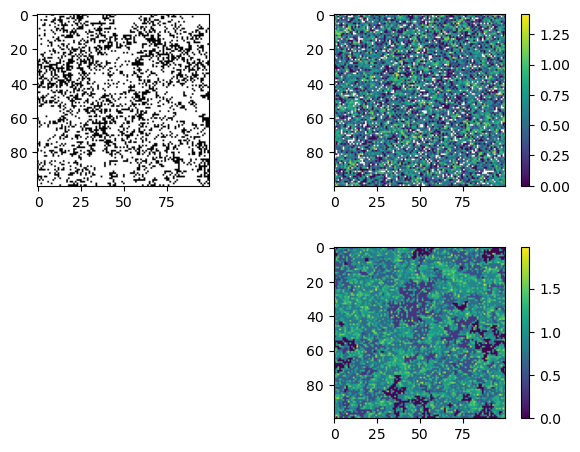

In [46]:
cm = PyPlot.cm

clf()
subplot(2,2,1)
# imshow(tree+4*fire, vmax=5, cmap=PyPlot.cm.Greys)
imshow(tree, cmap=PyPlot.cm.Greys)
# imshow(log.(fire), vmin=0.5, cmap=PyPlot.cm.Greys); colorbar()
subplot(2,2,2)
imshow(log10.(sincetree/ntyear)); colorbar()
subplot(2,2,4)
imshow(log10.(sincefire/ntyear)); colorbar()
gcf()

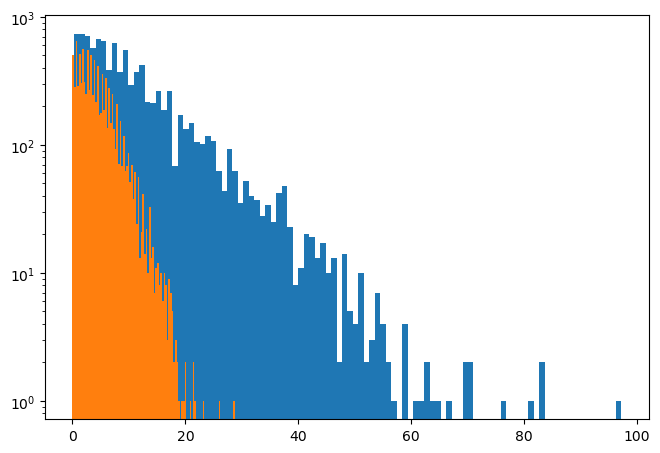

In [53]:
clf()
hist(sincefire[:]/ntyear, 100)
hist(sincetree[:]/ntyear, 100)
# plot([0, 8000], [5e3, 1.5])
# plot(0:100:8000, 5e3*exp.(-(0:100:8000)./988))
yscale("log")
gcf()
# slope is a factor of 5 per 2000 days
# 5e3 / 8000 days

In [43]:
log(5e3 / 1.5) # 8.1 factors of e per 8000
8.1/8000 # 0.0010125
8000/8.1

987.6543209876544

The fire frequency model for cells is
$$
    F = F_0 \exp(T_\mathrm{fire}/\tau_f)
$$
where $\tau_f = 988$ days and $T_\mathrm{fire}$ is the repeat interval between fires.

In [54]:
# 3D parameters
nd = 3 # dimensions
nx = 100

ntyear = 10 # growing-burning season
ntmature = ntyear * 10   # 10 years to maturity
ntignite = ntyear * 100 # lightning ignites each grid every 100 years
p_grow = 1/ntmature
p_ignite = 1/ntignite

# initialize
Random.seed!(42)

tree = falses(fill(nx, nd)...) # initialize array
sz = size(tree)
C = CartesianIndices(tree)
fire = falses(sz)

# diagnostics count days
# continuously incrementing, reset by events
sincetree = zeros(Int64, sz)
sincefire = zeros(Int64, sz)

# single step
step!(fire, tree, sincefire, sincetree)
any(fire)

false

In [55]:
# big run
nyear = 100
ndays = nyear * ntyear

for i in 1:ndays
    step!(fire, tree, sincefire, sincetree)
end

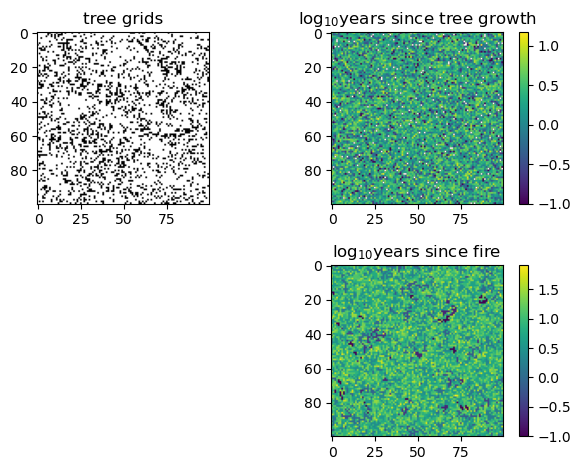

In [56]:
clf()
subplot(2,2,1)
imshow(tree[1,:,:], cmap=PyPlot.cm.Greys)
title("tree grids")

subplot(2,2,2)
imshow(log10.(sincetree[1,:,:]/ntyear)); colorbar()
title("log\$_{10}\$years since tree growth")

subplot(2,2,4)
imshow(log10.(sincefire[1,:,:]/ntyear)); colorbar()
title("log\$_{10}\$years since fire")
tight_layout()
gcf()

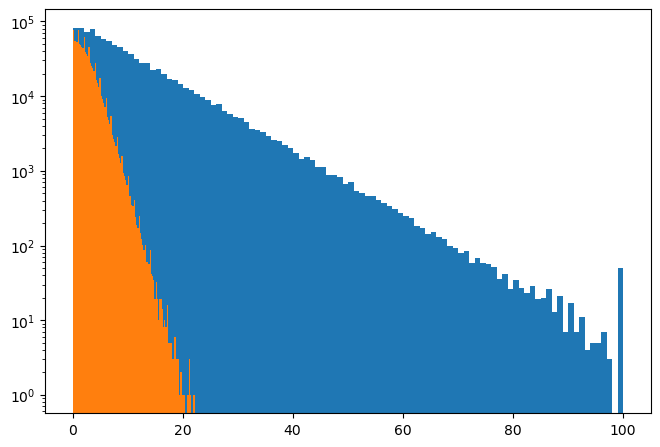

In [57]:
clf()
hist(sincefire[:]/ntyear, 100)
hist(sincetree[:]/ntyear, 100)
# plot([0, 8000], [5e3, 1.5])
# plot(0:100:8000, 5e3*exp.(-(0:100:8000)./988))
yscale("log")
gcf()